# Set Embeddings

In [ ]:
reinstall = True

In [ ]:
if reinstall == True:
  !pip install datasets
  !pip install sentence_transformers
  !pip install utils
  !pip install gensim nltk
  !pip install scikit-dimension

In [ ]:
import os
import numpy as np
import warnings
import itertools

from sklearn.metrics import accuracy_score

import os
import pickle
import numpy as np
import pandas as pd
import warnings
import itertools
import csv
import random
import matplotlib.pyplot as plt
random.seed(0)  # standardized default seed

import torch
from datasets import Dataset, load_dataset
import torch
import torch.nn.functional as F

import skdim

from utils import *
# from utils.feed_forward import FeedForward
# from utils.cls import extract_cls_embeddings
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skdim.id import TwoNN
from sklearn.metrics import matthews_corrcoef

In [ ]:
# Set Device ##########################################################
device_name = "cpu"  # default device is CPU
if torch.cuda.is_available():
    device_name = "cuda"  # CUDA for NVIDIA GPU
elif torch.backends.mps.is_available():
    device_name = torch.device("mps")  # Metal Performance Shaders for Apple M-series GPU
device = torch.device(device_name)
print(device_name)
#######################################################################

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Change these:

In [ ]:
# choose cached or not
cached = True
test_cached = True

# choose model
## 'MPNetBase'
## 'DistilRoBERTaBase'
## 'MPNetST'
## 'DistilRoBERTaST'
## 'GloVe100'
model_name = 'GloVe100'

emb_size = 768
if model_name == 'GloVe100':
  emb_size = 100

# choose task
## 'cola'
## 'sst2'
## 'mrpc'
## 'stsb'
## 'qqp'
## 'mnli_matched'
## 'mnli_mismatched'
## 'qnli'
## 'rte'
## 'wnli'
task = 'sst2'

two_sentence = True
if task == 'cola' or task == 'sst2':
  two_sentence = False

# choose type
## 'cls'
## 'mean_pooling'
## 'st'
## 'cbow'
emb_type = 'cbow'

# choose split
## 'train' (not applicable for mnli)
## 'val'
## 'test' (only applicable for mrpc)
split = 'train'
test_split = 'val'

# choose number of classes
## usually 2, 3 for mnli, regression for stsb (set to 5)
classes = 2
if task == 'mnli_matched' or task == 'mnli_mismatched':
  classes = 3
if task == 'stsb':
  classes = 5

# choose the number of isomap and t-sne components
## usually 2 or 3
n_isomap_components = 2
n_tsne_components = 2

## Set model

In [ ]:
if model_name == 'MPNetBase':
  from transformers import MPNetTokenizer, MPNetModel
  tokenizer = MPNetTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
  model = MPNetModel.from_pretrained("microsoft/mpnet-base").to(device)

In [ ]:
if model_name == 'DistilRoBERTaBase':
  from transformers import RobertaTokenizer, RobertaModel
  tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
  model = RobertaModel.from_pretrained('distilroberta-base').to(device)

In [ ]:
if model_name == 'MPNetST':
  from sentence_transformers import SentenceTransformer
  model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)

In [ ]:
if model_name == 'DistilRoBERTaST':
  from sentence_transformers import SentenceTransformer
  model = SentenceTransformer('sentence-transformers/all-distilroberta-v1').to(device)

In [ ]:
if model_name == 'GloVe100':
  import gensim.downloader as api
  model = api.load('glove-wiki-gigaword-100')  # or another model

[==================================================] 100.0% 128.1/128.1MB downloaded


## Load data

In [ ]:
data = load_dataset("glue", task)
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

## Run if embeddings have already been cached

In [ ]:
# assumes embeddings are saved in .npy files

if cached:

  file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_{split}_{model_name}.npy'
  X_emb = np.load(file_path)

  # set to |u-v| embedding
  if two_sentence:
    # set or just u-v if evaluating entailment
    if task == 'mnli' or task == 'qnli' or task == 'rte':
      X_emb = X_emb[:, 0:emb_size] - X_emb[:, emb_size:]
    else:
      X_emb = np.abs(X_emb[:, 0:emb_size] - X_emb[:, emb_size:])

  # Check the shape of the loaded embeddings
  print("X_emb shape:", X_emb.shape)

X_emb shape: (67349, 100)


In [ ]:
# assumes embeddings are saved in .npy files

if test_cached:

  file_path = f'/content/drive/My Drive/projectx_pain/embeddings/{emb_type}/{task}/X_{test_split}_{model_name}.npy'
  test_X_emb = np.load(file_path)

  # set to |u-v| embedding
  if two_sentence:
    # set or just u-v if evaluating entailment
    if task == 'mnli' or task == 'qnli' or task == 'rte':
      test_X_emb = test_X_emb[:, 0:emb_size] - test_X_emb[:, emb_size:]
    else:
      test_X_emb = np.abs(test_X_emb[:, 0:emb_size] - test_X_emb[:, emb_size:])

  # Check the shape of the loaded embeddings
  print("test_X_emb shape:", test_X_emb.shape)

test_X_emb shape: (872, 100)


In [ ]:
if cached:
  # Y_train = data["train"]["label"]
  # Y_val = data["validation"]["label"]
  # Y_test = data["test"]["label"]
  if split == 'val':
    Y_emb = data["validation"]["label"]
  else:
    Y_emb = data[split]["label"]

  print("Y_emb len:", len(Y_emb))

Y_emb len: 67349


In [ ]:
if test_cached:
  if test_split == 'val':
    test_Y_emb = data["validation"]["label"]
  else:
    test_Y_emb = data[test_split]["label"]

  print("test_Y_emb len:", len(test_Y_emb))

test_Y_emb len: 872


In [ ]:
if cached:
  # truncate to just the first 5000 examples so that it's easier to run

  print(np.min([5000, np.size(X_emb, 0)]))

  print(X_emb.shape)
  X_emb = X_emb[0:np.min([5000, np.size(X_emb, 0)]), :]
  Y_emb = Y_emb[0:np.min([5000, np.size(Y_emb)])]

  print("X_emb shape:", X_emb.shape)
  print("Y_emb len:", len(Y_emb))

5000
(67349, 100)
X_emb shape: (5000, 100)
Y_emb len: 5000


In [ ]:
if test_cached:
  # truncate to just the first 5000 examples so that it's easier to run

  print(np.min([5000, np.size(test_X_emb, 0)]))

  print(test_X_emb.shape)
  test_X_emb = test_X_emb[0:np.min([5000, np.size(test_X_emb, 0)]), :]
  test_Y_emb = test_Y_emb[0:np.min([5000, np.size(test_Y_emb)])]

  print("X_emb shape:", test_X_emb.shape)
  print("Y_emb len:", len(test_Y_emb))

872
(872, 100)
X_emb shape: (872, 100)
Y_emb len: 872


## Generate cls embeddings if needed
(note there is no generation of mean pooling; don't use this notebook if you don't already have cached mean pooled embeddings)

(NOT UPDATED TO INCLUDE TEST EMBEDDINGS BECAUSE I'M LAZY)

### Run for single sentence tasks; skip for double sentence tasks

In [ ]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### ONLY FOR SINGLE SENTENCES

  X_train = data["train"]["sentence"]
  X_val = data["validation"]["sentence"]
  X_test = data["test"]["sentence"]

  Y_train = data["train"]["label"]
  Y_val = data["validation"]["label"]
  Y_test = data["test"]["label"]

In [ ]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### ONLY FOR ONE SENTENCE

  X_train = tokenizer(X_train, padding=True, truncation=True, return_tensors='pt')
  X_val = tokenizer(X_val, padding=True, truncation=True, return_tensors='pt')
  X_test = tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')

In [ ]:
if not cached and emb_type == 'cls' and not two_sentence:
  ### 1s

  from torch.utils.data import DataLoader, TensorDataset

  def create_data_loader(tokenized_data, batch_size=512):
      dataset = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'])
      return DataLoader(dataset, batch_size=batch_size)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train)
  val_loader = create_data_loader(X_val)
  test_loader = create_data_loader(X_test)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_cls = get_cls_embeddings(train_loader)
  X_val_cls = get_cls_embeddings(val_loader)
  X_test_cls = get_cls_embeddings(test_loader)


In [ ]:
# save

if not cached and emb_type == 'cls' and not two_sentence:

  if split == 'train':
    X_emb = X_train_cls
    Y_emb = Y_train_cls
  elif split == 'val':
    X_emb = X_val_cls
    Y_emb = Y_val_cls
  else:
    X_emb = X_val_cls
    Y_emb = Y_val_cls

  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cls)
  np.save(path + f'X_test_{model_name}', X_test_cls)
  np.save(path + f'X_val_{model_name}', X_val_cls)

### Run for double sentence tasks; skip for single sentence tasks

In [ ]:
# this may error out if running on qqp, rte, qnli, or wnli

if not cached and emb_type == 'cls' and two_sentence:
  ### ONLY FOR TWO SENTENCES

  X_train_1 = data["train"]["sentence1"]
  X_train_2 = data["train"]["sentence2"]
  X_val_1 = data["validation"]["sentence1"]
  X_val_2 = data["validation"]["sentence2"]
  X_test_1 = data["test"]["sentence1"]
  X_test_2 = data["test"]["sentence2"]

  Y_train = data["train"]["label"]
  Y_val = data["validation"]["label"]
  Y_test = data["test"]["label"]

In [ ]:
if not cached and emb_type == 'cls' and two_sentence:
  ### ONLY FOR TWO SENTENCES

  X_train_1 = tokenizer(X_train_1, padding=True, truncation=True, return_tensors='pt')
  X_train_2 = tokenizer(X_train_2, padding=True, truncation=True, return_tensors='pt')
  X_val_1 = tokenizer(X_val_1, padding=True, truncation=True, return_tensors='pt')
  X_val_2 = tokenizer(X_val_2, padding=True, truncation=True, return_tensors='pt')
  X_test_1 = tokenizer(X_test_1, padding=True, truncation=True, return_tensors='pt')
  X_test_2 = tokenizer(X_test_2, padding=True, truncation=True, return_tensors='pt')

In [ ]:
if not cached and emb_type == 'cls' and two_sentence:
  ### 2s

  from torch.utils.data import DataLoader, TensorDataset

  def create_data_loader(tokenized_data, batch_size=512):
      dataset = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'])
      return DataLoader(dataset, batch_size=batch_size)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train_1)
  val_loader = create_data_loader(X_val_1)
  test_loader = create_data_loader(X_test_1)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
              print(len(cls_embeddings))
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_1_cls = get_cls_embeddings(train_loader)
  X_val_1_cls = get_cls_embeddings(val_loader)
  X_test_1_cls = get_cls_embeddings(test_loader)

  # Creating DataLoaders
  train_loader = create_data_loader(X_train_2)
  val_loader = create_data_loader(X_val_2)
  test_loader = create_data_loader(X_test_2)

  def get_cls_embeddings(data_loader):
      cls_embeddings = []
      for batch in data_loader:
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
          with torch.no_grad():
              outputs = model(**inputs)
              cls_embeddings_batch = outputs.last_hidden_state[:, 0, :]
              cls_embeddings.append(cls_embeddings_batch)
      return torch.cat(cls_embeddings, dim=0)

  # Extracting CLS embeddings
  X_train_2_cls = get_cls_embeddings(train_loader)
  X_val_2_cls = get_cls_embeddings(val_loader)
  X_test_2_cls = get_cls_embeddings(test_loader)

In [ ]:
# concatenate and save

if not cached and emb_type == 'cls' and two_sentence:
  X_train_cls = np.hstack((X_train_1_cls, X_train_2_cls))
  X_test_cls = np.hstack((X_test_1_cls, X_test_2_cls))
  X_val_cls = np.hstack((X_val_1_cls, X_val_2_cls))

  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cls)
  np.save(path + f'X_test_{model_name}', X_test_cls)
  np.save(path + f'X_val_{model_name}', X_val_cls)

  if split == 'train':
    X_emb = X_train_cls
    Y_emb = Y_train_cls
  elif split == 'val':
    X_emb = X_val_cls
    Y_emb = Y_val_cls
  else:
    X_emb = X_val_cls
    Y_emb = Y_val_cls

## Generate sentence transformer embeddings if needed

(NOT UPDATED TO INCLUDE TEST EMBEDDINGS BECAUSE I'M LAZY)

### Run for one sentence tasks

In [ ]:
if not cached and emb_type == 'st' and not two_sentence:

  # EXPENSIVE OPERATION: This cell may take about 2 minutes or more to run

  with torch.no_grad():
      X_train_st = model.encode(data["train"]["sentence"])
      X_val_st = model.encode(data["validation"]["sentence"])
      X_test_st = model.encode(data["test"]["sentence"])

      Y_train_st = np.array(data["train"]["label"])
      Y_val_st = np.array(data["validation"]["label"])
      Y_test_st = np.array(data["test"]["label"])

In [ ]:
if not cached and emb_type == 'st' and not two_sentence:

  if split == 'train':
    X_emb = X_train_st
    Y_emb = Y_train_st
  elif split == 'val':
    X_emb = X_val_st
    Y_emb = Y_val_st
  else:
    X_emb = X_val_st
    Y_emb = Y_val_st

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_st)
  np.save(path + f'X_test_{model_name}', X_test_st)
  np.save(path + f'X_val_{model_name}', X_val_st)

### Run for two sentence tasks

In [ ]:
if not cached and emb_type == 'st' and two_sentence:

  # EXPENSIVE OPERATION: This cell may take about 2 minutes or more to run

  if task == 'qnli':
    with torch.no_grad():
      X_train_1_st = model.encode(data["train"]["question"])
      X_train_2_st = model.encode(data["train"]["sentence"])
      X_val_1_st = model.encode(data["validation"]["question"])
      X_val_2_st = model.encode(data["validation"]["sentence"])
      X_test_1_st = model.encode(data["test"]["question"])
      X_test_2_st = model.encode(data["test"]["sentence"])

      Y_train_st = np.array(data["train"]["label"])
      Y_val_st = np.array(data["validation"]["label"])
      Y_test_st = np.array(data["test"]["label"])

  elif task == 'qqp' or task == 'rte':
    with torch.no_grad():
      X_train_1_st = model.encode(data["train"]["question1"][:5000])
      X_train_2_st = model.encode(data["train"]["question2"][:5000])
      X_val_1_st = model.encode(data["validation"]["question1"][:5000])
      X_val_2_st = model.encode(data["validation"]["question2"][:5000])
      X_test_1_st = model.encode(data["test"]["question1"][:5000])
      X_test_2_st = model.encode(data["test"]["question2"][:5000])

      Y_train_st = np.array(data["train"]["label"])
      Y_val_st = np.array(data["validation"]["label"])
      Y_test_st = np.array(data["test"]["label"])

  else:
    with torch.no_grad():
        X_train_1_st = model.encode(data["train"]["sentence1"])
        X_train_2_st = model.encode(data["train"]["sentence2"])
        X_val_1_st = model.encode(data["validation"]["sentence1"])
        X_val_2_st = model.encode(data["validation"]["sentence2"])
        X_test_1_st = model.encode(data["test"]["sentence1"])
        X_test_2_st = model.encode(data["test"]["sentence2"])

        Y_train_st = np.array(data["train"]["label"])
        Y_val_st = np.array(data["validation"]["label"])
        Y_test_st = np.array(data["test"]["label"])

In [ ]:
if not cached and emb_type == 'st' and two_sentence:

  # concatenate
  X_train_st = np.hstack((X_train_1_st, X_train_2_st))
  X_test_st = np.hstack((X_test_1_st, X_test_2_st))
  X_val_st = np.hstack((X_val_1_st, X_val_2_st))

  if split == 'train':
    X_emb = X_train_st
    Y_emb = Y_train_st
  elif split == 'val':
    X_emb = X_val_st
    Y_emb = Y_val_st
  else:
    X_emb = X_val_st
    Y_emb = Y_val_st

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_st)
  np.save(path + f'X_test_{model_name}', X_test_st)
  np.save(path + f'X_val_{model_name}', X_val_st)

## Generate cbow embeddings if needed

(NOT UPDATED TO INCLUDE TEST EMBEDDINGS BECAUSE I'M LAZY)

In [ ]:
if not cached and emb_type == 'cbow':

  # define generating function (not that kind)

  from nltk.tokenize import word_tokenize
  import nltk
  nltk.download('punkt')

  def generate_cbow_embeddings(sentences, model):
      embeddings = []
      for sentence in sentences:
          tokens = word_tokenize(sentence.lower())
          valid_tokens = [token for token in tokens if token in model.key_to_index]
          if valid_tokens:
              sentence_embedding = np.mean([model[token] for token in valid_tokens], axis=0)
          else:
              sentence_embedding = np.zeros(model.vector_size)
          embeddings.append(sentence_embedding)
      return np.array(embeddings)

### Run for one sentence tasks

In [ ]:
if not cached and emb_type == 'cbow' and not two_sentence:

    X_train_cbow = generate_cbow_embeddings(data['train']['sentence'], model)
    X_test_cbow = generate_cbow_embeddings(data['test']['sentence'], model)
    X_val_cbow = generate_cbow_embeddings(data['validation']['sentence'], model)

    Y_train_cbow = np.array(data["train"]["label"])
    Y_val_cbow = np.array(data["validation"]["label"])
    Y_test_cbow = np.array(data["test"]["label"])

In [ ]:
if not cached and emb_type == 'cbow' and not two_sentence:

  if split == 'train':
    X_emb = X_train_
    Y_emb = Y_train_
  elif split == 'val':
    X_emb = X_val_
    Y_emb = Y_val_
  else:
    X_emb = X_val_
    Y_emb = Y_val_

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  np.save(path + f'X_train_{model_name}', X_train_cbow)
  np.save(path + f'X_test_{model_name}', X_test_cbow)
  np.save(path + f'X_val_{model_name}', X_val_cbow)

### Run for two sentence tasks

In [ ]:
# FIX THIS

if not cached and emb_type == 'cbow' and two_sentence:

    if task == 'qnli':
      if split == 'train':
        X_train_1_cbow = generate_cbow_embeddings(data['train']['question'], model)
        X_train_2_cbow = generate_cbow_embeddings(data['train']['sentence'], model)
        X_train_cbow = np.hstack((X_train_1_cbow, X_train_2_cbow))
        Y_train_cbow = np.array(data["train"]["label"])
      if split == 'test':
        X_test_1_cbow = generate_cbow_embeddings(data['test']['question'], model)
        X_test_2_cbow = generate_cbow_embeddings(data['test']['sentence'], model)
        X_test_cbow = np.hstack((X_test_1_cbow, X_test_2_cbow))
        Y_test_cbow = np.array(data["test"]["label"])
      if split == 'val':
        X_val_1_cbow = generate_cbow_embeddings(data['validation']['question'], model)
        X_val_2_cbow = generate_cbow_embeddings(data['validation']['sentence'], model)
        X_val_cbow = np.hstack((X_val_1_cbow, X_val_2_cbow))
        Y_val_cbow = np.array(data["validation"]["label"])

    if task == 'mnli_matched' or task == 'mnli_mismatched':
      if split == 'train':
        X_train_1_cbow = generate_cbow_embeddings(data['train']['premise'], model)
        X_train_2_cbow = generate_cbow_embeddings(data['train']['hypothesis'], model)
        X_train_cbow = np.hstack((X_train_1_cbow, X_train_2_cbow))
        Y_train_cbow = np.array(data["train"]["label"])
      if split == 'test':
        X_test_1_cbow = generate_cbow_embeddings(data['test']['premise'], model)
        X_test_2_cbow = generate_cbow_embeddings(data['test']['hypothesis'], model)
        X_test_cbow = np.hstack((X_test_1_cbow, X_test_2_cbow))
        Y_test_cbow = np.array(data["test"]["label"])
      if split == 'val':
        X_val_1_cbow = generate_cbow_embeddings(data['validation']['premise'], model)
        X_val_2_cbow = generate_cbow_embeddings(data['validation']['hypothesis'], model)
        X_val_cbow = np.hstack((X_val_1_cbow, X_val_2_cbow))
        Y_val_cbow = np.array(data["validation"]["label"])

    if task == 'qqp' or task == 'rte':
      if split == 'train':
        X_train_1_cbow = generate_cbow_embeddings(data['train']['question1'], model)
        X_train_2_cbow = generate_cbow_embeddings(data['train']['question2'], model)
        X_train_cbow = np.hstack((X_train_1_cbow, X_train_2_cbow))
        Y_train_cbow = np.array(data["train"]["label"])
      if split == 'test':
        X_test_1_cbow = generate_cbow_embeddings(data['test']['question1'], model)
        X_test_2_cbow = generate_cbow_embeddings(data['test']['question2'], model)
        X_test_cbow = np.hstack((X_test_1_cbow, X_test_2_cbow))
        Y_test_cbow = np.array(data["test"]["label"])
      if split == 'val':
        X_val_1_cbow = generate_cbow_embeddings(data['validation']['question1'], model)
        X_val_2_cbow = generate_cbow_embeddings(data['validation']['question2'], model)
        X_val_cbow = np.hstack((X_val_1_cbow, X_val_2_cbow))
        Y_val_cbow = np.array(data["validation"]["label"])


    else:
      if split == 'train':
        X_train_1_cbow = generate_cbow_embeddings(data['train']['sentence1'], model)
        X_train_2_cbow = generate_cbow_embeddings(data['train']['sentence2'], model)
        X_train_cbow = np.hstack((X_train_1_cbow, X_train_2_cbow))
        Y_train_cbow = np.array(data["train"]["label"])
      if split == 'test':
        X_test_1_cbow = generate_cbow_embeddings(data['test']['sentence1'], model)
        X_test_2_cbow = generate_cbow_embeddings(data['test']['sentence2'], model)
        X_test_cbow = np.hstack((X_test_1_cbow, X_test_2_cbow))
        Y_test_cbow = np.array(data["test"]["label"])
      if split == 'val':
        X_val_1_cbow = generate_cbow_embeddings(data['validation']['sentence1'], model)
        X_val_2_cbow = generate_cbow_embeddings(data['validation']['sentence2'], model)
        X_val_cbow = np.hstack((X_val_1_cbow, X_val_2_cbow))
        Y_val_cbow = np.array(data["validation"]["label"])

In [ ]:
if not cached and emb_type == 'cbow' and two_sentence:

  # Save to the mounted Google Drive
  path = f'/content/drive/MyDrive/projectx_pain/embeddings/{emb_type}/{task}/'
  os.makedirs(path, exist_ok=True)  # This creates the directory if it doesn't exist

  if split == 'train':
    X_emb = X_train_cbow
    Y_emb = Y_train_cbow
    np.save(path + f'X_train_{model_name}', X_train_cbow)
  elif split == 'val':
    X_emb = X_val_cbow
    Y_emb = Y_val_cbow
    np.save(path + f'X_val_{model_name}', X_val_cbow)
  else:
    X_emb = X_test_cbow
    Y_emb = Y_test_cbow
    np.save(path + f'X_test_{model_name}', X_test_cbow)

## Set to |u-v| or u-v embeddings and truncate

In [ ]:
# set to |u-v| embedding
if not cached and two_sentence:
  # or just u-v if evaluating entailment
  if task == 'mnli_matched' or task == 'mnli_mismatched' or task == 'qnli' or task == 'rte':
    X_emb = X_emb[:, 0:emb_size] - X_emb[:, emb_size:]
  else:
    X_emb = np.abs(X_emb[:, 0:emb_size] - X_emb[:, emb_size:])

  # truncate to just the first 5000 examples so that it's easier to run
  print(np.min([5000, np.size(X_emb, 0)]))
  print(X_emb.shape)
  X_emb = X_emb[0:np.min([5000, np.size(X_emb, 0)]), :]
  Y_emb = Y_emb[0:np.min([5000, np.size(Y_emb)])]
  print("X_emb shape:", X_emb.shape)
  print("Y_emb len:", len(Y_emb))

# Manifold Learning

## Set up text file to write results to

In [ ]:
# Specify the path for the folder and the file
folder_path = f'/content/drive/My Drive/projectx_pain/results_part2/{task}-{model_name}-{emb_type}-train_{split}-test_{test_split}'

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## RandPCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as RandomizedPCA
randPCA_model = RandomizedPCA(emb_size).fit(X_emb)

In [ ]:
# Estimate intrinsic dimensionality based on different thresholds

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-RandPCAThresholds.txt')

# Assuming model.explained_variance_ratio_ is the variance ratio array from PCA
cumulative_variance = np.cumsum(randPCA_model.explained_variance_ratio_)

# Thresholds
thresholds = [0.6, 0.8, 0.9, 0.95, 0.975]

# Finding the number of components for each threshold
n_components_for_threshold = {}
for threshold in thresholds:
    print(threshold)
    n_components = np.where(cumulative_variance >= threshold)[0][0] + 1  # Adding 1 because of 0-indexing
    n_components_for_threshold[threshold] = n_components

print(n_components_for_threshold)

# Write to file
with open(txt_file_path, 'w') as file:
    file.write('Randomized PCA intrinsic dimensionality estimates given threshold\n')
    file.write(str(n_components_for_threshold) + '\n')
print(f"File written at {txt_file_path}")

In [ ]:
plt.plot(np.cumsum(randPCA_model.explained_variance_ratio_))
# Adding a horizontal line at 0.9 threshold
plt.axhline(y=0.9, color='r', linestyle='--')

# Adding a vertical line at the point where the cumulative variance reaches 0.9
plt.axvline(x=n_components_for_threshold[0.9], color='r', linestyle='--')
# Annotating the intersection point
plt.annotate(f'{n_components_for_threshold[0.9]} components', (n_components_for_threshold[0.9], 0.9), textcoords="offset points", xytext=(-10,-10), ha='center')

plt.xlabel('n components')
plt.ylabel('cumulative variance');
plt.title(f'Estimated variance over n-component RandPCA ({task}, {model_name}, {emb_type}, train: {split})')
# plt.show()


# Save plot

# Specify the path for the folder and the plot file
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-RandPCA.png')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")

In [ ]:
test_randPCA_model = RandomizedPCA(emb_size).fit(test_X_emb)

In [ ]:
# Estimate intrinsic dimensionality based on different thresholds

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-RandPCAThresholds.txt')

# Assuming model.explained_variance_ratio_ is the variance ratio array from PCA
cumulative_variance = np.cumsum(test_randPCA_model.explained_variance_ratio_)

# Thresholds
thresholds = [0.6, 0.8, 0.9, 0.95, 0.975]

# Finding the number of components for each threshold
n_components_for_threshold = {}
for threshold in thresholds:
    print(threshold)
    n_components = np.where(cumulative_variance >= threshold)[0][0] + 1  # Adding 1 because of 0-indexing
    n_components_for_threshold[threshold] = n_components

print(n_components_for_threshold)

# Write to file
with open(txt_file_path, 'w') as file:
    file.write('Randomized PCA intrinsic dimensionality estimates given threshold\n')
    file.write(str(n_components_for_threshold) + '\n')
print(f"File written at {txt_file_path}")

In [ ]:
plt.plot(np.cumsum(test_randPCA_model.explained_variance_ratio_))
# Adding a horizontal line at 0.9 threshold
plt.axhline(y=0.9, color='r', linestyle='--')

# Adding a vertical line at the point where the cumulative variance reaches 0.9
plt.axvline(x=n_components_for_threshold[0.9], color='r', linestyle='--')
# Annotating the intersection point
plt.annotate(f'{n_components_for_threshold[0.9]} components', (n_components_for_threshold[0.9], 0.9), textcoords="offset points", xytext=(-10,-10), ha='center')

plt.xlabel('n components')
plt.ylabel('cumulative variance');
plt.title(f'Estimated variance over n-component RandPCA ({task}, {model_name}, {emb_type}, test: {test_split})')

# Save plot

# Specify the path for the folder and the plot file
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-RandPCA.png')

# Check if the folder exists, create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")

## SKLearn Bonanza (intrinsic dimensionality)

In [ ]:
# estimate global and local intrinsic dimension of X_emb using different estimators from sklearn

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import manifold
import skdim

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-inputLPCAIDests.txt')
# estimate local intrinsic dimension (dimension in k-NN around each points)
lpca = skdim.id.lPCA().fit_pw(X_emb, n_neighbors = 20, n_jobs = 1)
print('local (lPCA) = ', np.mean(lpca.dimension_pw_))
# Write to file
with open(txt_file_path, 'w') as file:
    file.write('lPCA ID est:\n')
    file.write(str([np.mean(lpca.dimension_pw_)]))
print(f"File written at {txt_file_path}")

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-inputLPCAIDests.txt')
lpca = skdim.id.lPCA().fit_pw(test_X_emb, n_neighbors = 20, n_jobs = 1)
print('local (lPCA) = ', np.mean(lpca.dimension_pw_))
# Write to file
with open(txt_file_path, 'w') as file:
    file.write('lPCA ID est:\n')
    file.write(str([np.mean(lpca.dimension_pw_)]))
print(f"File written at {txt_file_path}")


local (lPCA) =  16.8238
File written at /content/drive/My Drive/projectx_pain/results_part2/sst2-GloVe100-cbow-train_train-test_val/sst2-GloVe100-cbow-train_train-inputLPCAIDests.txt
local (lPCA) =  18.857798165137616
File written at /content/drive/My Drive/projectx_pain/results_part2/sst2-GloVe100-cbow-train_train-test_val/sst2-GloVe100-cbow-test_val-inputLPCAIDests.txt


## TwoNN

In [ ]:
# TwoNN dimensionality of embeddings

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-inputTwoNNIDests.txt')
twoNNIdEst = TwoNN().fit_transform(X_emb)
print('twoNN ID est = ', twoNNIdEst)
# Write to file
with open(txt_file_path, 'w') as file:
    file.write('twoNN ID est:\n')
    file.write(str([twoNNIdEst]))
print(f"File written at {txt_file_path}")

txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-inputTwoNNIDests.txt')
twoNNIdEst = TwoNN().fit_transform(test_X_emb)
print('twoNN ID est = ', twoNNIdEst)
# Write to file
with open(txt_file_path, 'w') as file:
    file.write('twoNN ID est:\n')
    file.write(str([twoNNIdEst]))
print(f"File written at {txt_file_path}")

twoNN ID est =  7.936218524742606
File written at /content/drive/My Drive/projectx_pain/results_part2/sst2-GloVe100-cbow-train_train-test_val/sst2-GloVe100-cbow-train_train-inputTwoNNIDests.txt
twoNN ID est =  27.16221658962008
File written at /content/drive/My Drive/projectx_pain/results_part2/sst2-GloVe100-cbow-train_train-test_val/sst2-GloVe100-cbow-test_val-inputTwoNNIDests.txt


In [ ]:
#convert X_emb to float
X_emb_2nn = X_emb.astype(float)
# convert Y_emb to one-hot encodings and convert to float
Y_emb_2nn = np.eye(2)[Y_emb].astype(float)
# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_emb_2nn), torch.LongTensor(Y_emb_2nn))

In [ ]:
#convert test_X_emb to float
test_X_emb_2nn = test_X_emb.astype(float)
# convert test_Y_emb to one-hot encodings and convert to float
test_Y_emb_2nn = np.eye(2)[test_Y_emb].astype(float)
# Convert to PyTorch tensors
test_data = TensorDataset(torch.FloatTensor(test_X_emb_2nn), torch.LongTensor(test_Y_emb_2nn))

In [ ]:
# For each desired number of hidden layers, create and train a separate model
bc = 32
hidden_layer_configs = [2]
input_size = emb_size
hidden_size = emb_size
num_epochs = 100
output_size = classes
learning_rate = 0.01

# Early stopping parameters
patience = 10
min_delta = 0
weight_decay = 0.01

In [ ]:
# DataLoader
train_loader = DataLoader(train_data, batch_size=bc, shuffle=False)
test_loader = DataLoader(test_data, batch_size=bc, shuffle=False)

In [ ]:
print(np.shape(test_X_emb_2nn))

(872, 100)


In [ ]:
class FFN(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super(FFN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, output_size))
        # layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # print(f'in FFN, shape of self.model(x) = %f', np.shape(self.model(x))) # REMOVE
        return self.model(x)

    def get_intermediate_layers(self, x):
        intermediate_outputs = []
        with torch.no_grad():
            for layer in self.model:
                x = layer(x)
                if isinstance(layer, nn.ReLU):
                    intermediate_outputs.append(x.detach().cpu().numpy())
        return intermediate_outputs # has shape [num hidden layers, batch size, 768]

In [ ]:
for num_hidden_layers in hidden_layer_configs:
    print(f"Training model with {num_hidden_layers} hidden layers")
    model = FFN(input_size=input_size, num_hidden_layers=num_hidden_layers, hidden_size=hidden_size, output_size=output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables for early stopping
    best_loss = float('inf')
    patience_counter = 0

    txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-IDPerEpochPerLayer-{num_hidden_layers}.txt')
    with open(txt_file_path, 'w') as file:
        file.write(f"\nnumber of hidden layers: \n")
        file.write(str(num_hidden_layers))

    # Training loop with ID tracking.

    model.train()
    epoch = 0
    training_losses = []
    validation_losses = []

    while epoch < num_epochs:
        outputs_per_layer = []
        stupid_dumbass_variable = True
        training_loss = 0.0
        validation_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            training_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Track ID
            intermediate_outputs = model.get_intermediate_layers(inputs)
            if stupid_dumbass_variable:
              outputs_per_layer = intermediate_outputs
              stupid_dumbass_variable = False
            else:
              outputs_per_layer = np.concatenate((outputs_per_layer, intermediate_outputs), axis=1)

        training_losses.append(training_loss / len(Y_emb))

        # Validation phase
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:  # Assuming you have a validation loader 'val_loader'
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels.float())
                validation_loss += val_loss.item()

        validation_losses.append(validation_loss / len(test_Y_emb))

        # Calculate the ID per layer for the epoch
        lPCA_per_layer = np.zeros(num_hidden_layers)
        twoNN_per_layer = np.zeros(num_hidden_layers)
        for i in range(num_hidden_layers):
            # lPCA_per_layer[i] = np.mean(skdim.id.lPCA().fit_pw(outputs_per_layer[i], n_neighbors = 20, n_jobs = 1).dimension_pw_) # UNCOMMENT
            twoNN_per_layer[i] = TwoNN().fit_transform(outputs_per_layer[i])

        # print(f"Epoch {epoch+1}, lPCA_per_layer: ", lPCA_per_layer) # UNCOMMENT
        print(f"Epoch {epoch+1}, twoNN_per_layer: ", twoNN_per_layer)

        with open(txt_file_path, 'a') as file: # UNCOMMENT
            # file.write(f"\nEpoch {epoch+1}, lPCA_per_layer: \n") # UNCOMMENT
            # file.write(str(lPCA_per_layer))
            file.write(f"\nEpoch {epoch+1}, twoNN_per_layer: \n")
            file.write(str(twoNN_per_layer))
        print(f"File written at {txt_file_path}")

        # At the end of each epoch, check if early stopping should be triggered
        if validation_loss < best_loss - min_delta:
            best_loss = validation_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Stopping early due to no improvement")
            # set epoch to last epoch to do t-sne plots and then break
            epoch = num_epochs - 1

        # t-SNE stuff - only do this for the last epoch because it's lowkey time consuming
        if False and epoch == num_epochs - 1 and num_hidden_layers in {1, 2, 3, 5}:

            from sklearn.decomposition import PCA
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D

            for i in range(num_hidden_layers):

                # Apply t-SNE
                perp = int(np.floor(len(outputs_per_layer[i]) / classes))
                tsne = TSNE(n_components=n_tsne_components, random_state=0, perplexity=perp, init="pca")
                tsne_embeddings = tsne.fit_transform(outputs_per_layer[i])

                # Plot

                point_size = 2

                if n_tsne_components == 2:
                  plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=point_size, c=Y_emb, cmap='viridis')
                  plt.title(f'2D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}, train: {split}, layer {i+1})')
                elif n_tsne_components == 3:
                  fig = plt.figure(figsize=(12, 8))
                  ax = fig.add_subplot(111, projection='3d')
                  ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], s=point_size, c=Y_emb, cmap='viridis')
                  ax.set_title(f'3D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}, train: {split}, layer {i+1})')

                plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-layer{i+1}({num_hidden_layers})-tSNE.png')

                # Save the plot
                plt.savefig(plot_file_path)
                plt.show()

                print(f"Plot saved at {plot_file_path}")

        # increment epoch
        epoch += 1

    # Plotting training and validation loss
    plt.figure(figsize=(12, 8))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-train_{split}-tvLoss-nl({num_hidden_layers})-ep({num_epochs})-bc({bc})-pa({patience}).png')
    plt.savefig(plot_file_path)
    plt.show()
    print(f"Plot saved at {plot_file_path}")


    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        outputs_per_layer = []
        predictions = []
        stupid_dumbass_variable = True # is this the first batch
        for inputs, labels in test_loader:
            outputs = model(inputs)

            intermediate_outputs = model.get_intermediate_layers(inputs)
            if stupid_dumbass_variable:
                outputs_per_layer = intermediate_outputs
                predictions = outputs
                stupid_dumbass_variable = False
            else:
                outputs_per_layer = np.concatenate((outputs_per_layer, intermediate_outputs), axis=1)
                predictions = np.concatenate((predictions, outputs), axis=0)

        # Calculate the ID per layer for the epoch
        lPCA_per_layer = np.zeros(num_hidden_layers)
        twoNN_per_layer = np.zeros(num_hidden_layers)
        for i in range(num_hidden_layers):
            lPCA_per_layer[i] = np.mean(skdim.id.lPCA().fit_pw(outputs_per_layer[i], n_neighbors = 20, n_jobs = 1).dimension_pw_)
            twoNN_per_layer[i] = TwoNN().fit_transform(outputs_per_layer[i])

        print(f"lPCA_per_layer: ", lPCA_per_layer)
        print(f"twoNN_per_layer: ", twoNN_per_layer)

        txt_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-data-{num_hidden_layers}.txt')
        with open(txt_file_path, 'w') as file:
            file.write(f"\nnumber of hidden layers: \n")
            file.write(str(num_hidden_layers))
            file.write(f"\nlPCA_per_layer: \n")
            file.write(str(lPCA_per_layer))
            file.write(f"\ntwoNN_per_layer: \n")
            file.write(str(twoNN_per_layer))
        print(f"File written at {txt_file_path}")

        if test_Y_emb[0] != -1:
            acc = 100 * sum(test_Y_emb == np.argmax(predictions, axis=1)) / len(test_Y_emb)
            mcc = matthews_corrcoef(test_Y_emb, np.argmax(predictions, axis=1))
            print("Accuracy on the test set: " + str(acc))
            print("MCC Score: " + str(mcc))
            with open(txt_file_path, 'a') as file:
                file.write(f"\nAccuracy on the test set: \n")
                file.write(str(acc))
                file.write(f"\nMCC Score: \n")
                file.write(str(mcc))
            print(f"File written at {txt_file_path}")


    # t-SNE stuff - colors correspond to PREDICTED values if true labels are unavailable
    if num_hidden_layers in {1, 2, 3, 5}:

        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        for i in range(num_hidden_layers):

            # Apply t-SNE
            perp = int(np.floor(len(outputs_per_layer[i]) / classes))
            tsne = TSNE(n_components=n_tsne_components, random_state=0, perplexity=perp, init="pca")
            tsne_embeddings = tsne.fit_transform(outputs_per_layer[i])

            # Plot

            point_size = 2

            if test_Y_emb[0] != -1:
                colors = test_Y_emb
            else:
                colors = predictions[:,0]

            if n_tsne_components == 2:
              plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=point_size, c=colors, cmap='viridis')
              plt.title(f'2D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}, test: {test_split}, layer {i+1})')
            elif n_tsne_components == 3:
              fig = plt.figure(figsize=(12, 8))
              ax = fig.add_subplot(111, projection='3d')
              ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], s=point_size, c=colors, cmap='viridis')
              ax.set_title(f'3D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}, test: {test_split}, layer {i+1})')

            plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-layer{i+1}({num_hidden_layers})-tSNE.png')

            # Save the plot
            plt.savefig(plot_file_path)
            plt.show()

            print(f"Plot saved at {plot_file_path}")

In [ ]:
perp = int(np.floor(len(predictions[:,0]) / classes))
tsne = TSNE(n_components=n_tsne_components, random_state=0, perplexity=perp, init="pca")
tsne_embeddings = tsne.fit_transform(predictions)
plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:, 1], s=point_size, c=test_Y_emb, cmap='viridis')

In [ ]:
plt.scatter(predictions[:,0], predictions[:, 1], s=point_size, c=test_Y_emb, cmap='viridis')

## t-SNE
t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. t-SNE usually doesn't handle very high

In [ ]:
# TESTING PLAYGROUND

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# # Apply PCA
# pca = PCA(n_components=50)
# reduced_embeddings = pca.fit_transform(X_emb) # if this errors out try adding a .numpy() to the end of X_emb



# Apply t-SNE
perp = int(np.floor(len(X_emb) / classes))
tsne = TSNE(n_components=n_tsne_components, random_state=0, perplexity=perp, init="pca")
tsne_embeddings = tsne.fit_transform(X_emb)

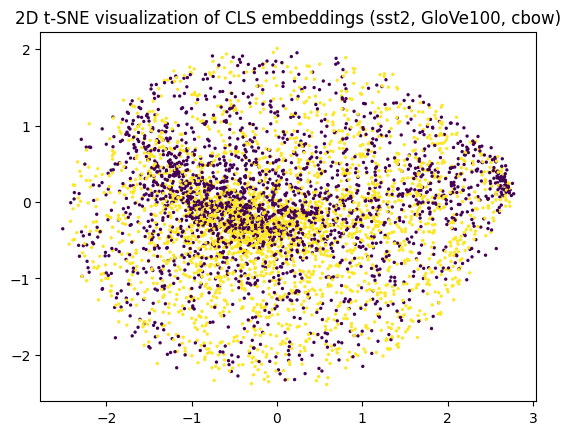

Plot saved at /content/drive/My Drive/projectx_pain/results_part2/sst2-GloVe100-cbow-train_train-test_val/sst2-GloVe100-cbow-test_val-layer0(2)-tSNE.png


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point_size = 2

if n_tsne_components == 2:
  plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=point_size, c=Y_emb, cmap='viridis')
  plt.title(f'2D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type})')
elif n_tsne_components == 3:
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], s=point_size, c=Y_emb, cmap='viridis')
  ax.set_title(f'3D t-SNE visualization of CLS embeddings ({task}, {model_name}, {emb_type}')


# Save plot

# Specify the path for the folder and the plot file
plot_file_path = os.path.join(folder_path, f'{task}-{model_name}-{emb_type}-test_{test_split}-layer{0}({num_hidden_layers})-tSNE.png')

# Save the plot
plt.savefig(plot_file_path)
plt.show()

print(f"Plot saved at {plot_file_path}")